# Seedings Classification (CNN)
Kunlun Liu

Bolog Link
https://medium.com/@kunlun.liu/plant-seedings-classification-df70dff36b17

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [5]:
species = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen',
          'Loose Silky-bent', 'Maize','Scentless Mayweed', 'Shepherds Purse',
          'Small-flowered Cranesbill', 'Sugar beet']
data_dir = 'D:/PyCharm Files/plant/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [6]:
# Organize training files into DataFrame
train_data = []
for species_id, sp in enumerate(species):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['train/{}/{}'.format(sp, file), species_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'SpeciesId','Species'])
train.head()

,File,SpeciesId,Species
0,train/Black-grass/0050f38b3.png,0,Black-grass
1,train/Black-grass/0183fdf68.png,0,Black-grass
2,train/Black-grass/0260cffa8.png,0,Black-grass
3,train/Black-grass/05eedce4d.png,0,Black-grass
4,train/Black-grass/075d004bc.png,0,Black-grass


In [7]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,SpeciesId,Species
0,train/Shepherds Purse/cd3e9d61c.png,9,Shepherds Purse
1,train/Common Chickweed/2e5123448.png,3,Common Chickweed
2,train/Charlock/168982d9c.png,1,Charlock
3,train/Fat Hen/994001cab.png,5,Fat Hen
4,train/Common wheat/a86689d83.png,4,Common wheat


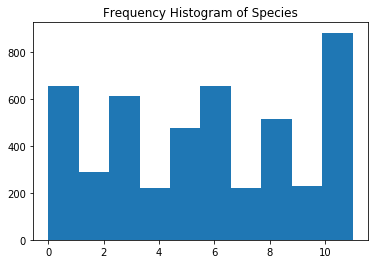

In [8]:
# Plot a histogram
plt.hist(train['SpeciesId'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

In [9]:
# Organize test files into DataFrame
test_data = []
for file in os.listdir(test_dir):
    test_data.append(['test/{}'.format(file), file])
test = pd.DataFrame(test_data, columns=['Filepath', 'File'])
test.head()

,Filepath,File
0,test/0021e90e4.png,0021e90e4.png
1,test/003d61042.png,003d61042.png
2,test/007b3da8b.png,007b3da8b.png
3,test/0086a6340.png,0086a6340.png
4,test/00c47e980.png,00c47e980.png


# Plot training images

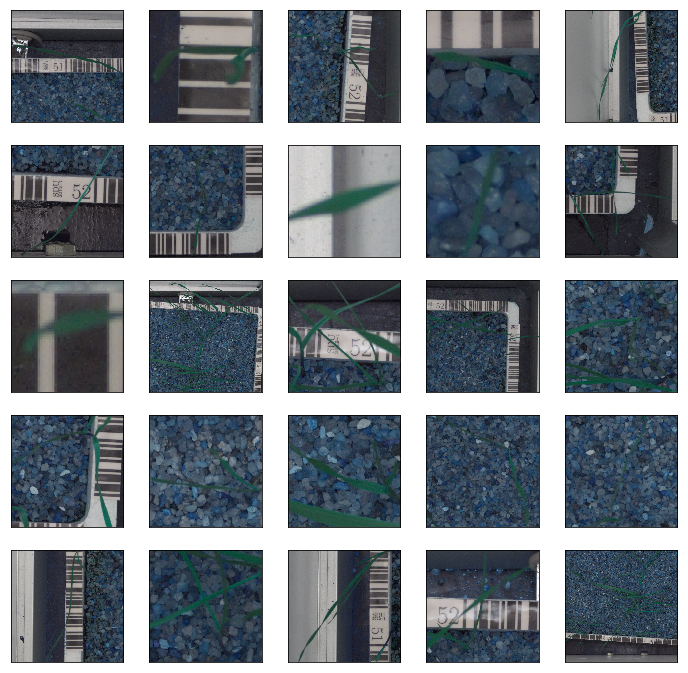

In [10]:
# Display images for different species
def plot_species(species, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    species_files = train['File'][train['Species'] == species].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, species_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_species('Black-grass', 5, 5)

# Preprocessing

In [11]:
IMAGE_SIZE = 66

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [12]:
# Image segmentation
def create_mask(image):
    # Convert from BGR to HSV color-space to extract colored object
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Define range of green in HSV
    lower_green = np.array([30, 100, 50])
    upper_green = np.array([85, 255, 255])
    # Threshold the HSV image to get only green colors
    mask = cv2.inRange(image_hsv, lower_green, upper_green)
    # We will use a morphological operation called closing to close small holes in the image
    # We need a kernel or structuring element to determine the nature of the operation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

def segment_image(image):
    mask = create_mask(image)
    res = cv2.bitwise_and(image, image, mask=mask) # Bitwise-AND mask and original image
    return res

# Plot segmented images

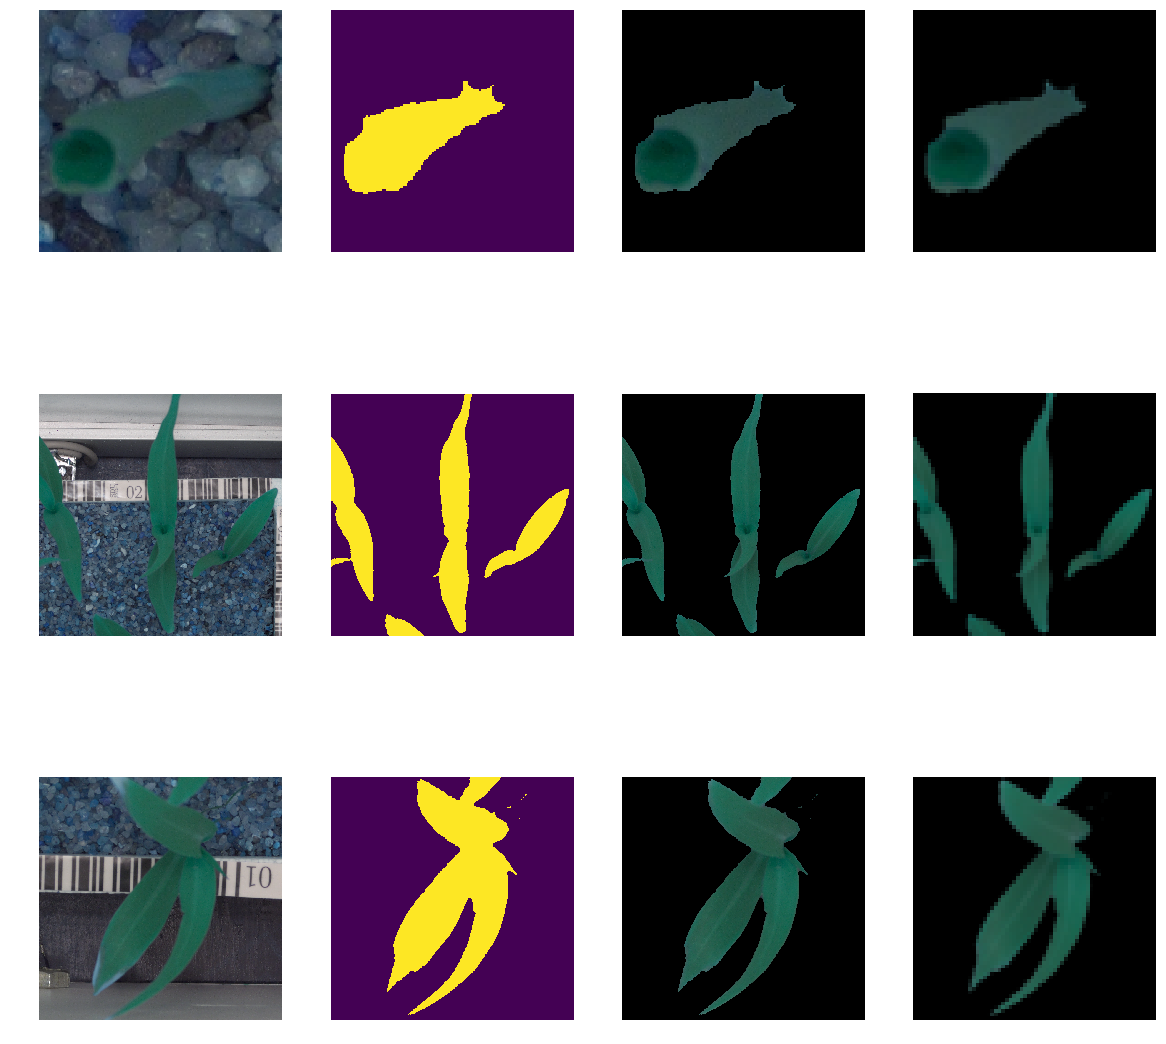

In [13]:
def show_segmented_images(species, n):
    fig, ax = plt.subplots(n, 4, figsize=(20, 20))
    species_files = train['File'][train['Species'] == species].values
    for i in range(n):
        image = read_image(species_files[i])
        image_masked = create_mask(image)
        image_segmented = segment_image(image)
        image_resized = resize_image(image_segmented, (IMAGE_SIZE, IMAGE_SIZE))
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()
        ax[i, 3].set_axis_off()
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(image_masked)
        ax[i, 2].imshow(image_segmented)
        ax[i, 3].imshow(image_resized)
# Displays first n images of class from training set
show_segmented_images('Maize', 3)

# Extract features

In [14]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    image_segmented = segment_image(image)
    X_train[i] = resize_image(image_segmented, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_train = X_train / 255.
print('Train Shape: {}'.format(X_train.shape))

4750it [02:01, 39.02it/s]


Train Shape: (4750, 66, 66, 3)


# Label encoding

In [15]:
Y_train = train['SpeciesId'].values
Y_train = to_categorical(Y_train, num_classes=12)

# Split traning and validation set

In [16]:
BATCH_SIZE = 16
EPOCHS = 75

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=SEED)

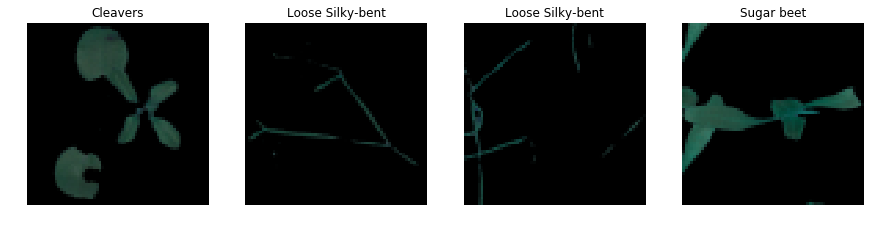

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
for i in range(4):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(species[np.argmax(Y_train[i])])

# CNN Model

In [18]:
def construct_model():
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                activation='relu'))
    model.add(BatchNormalization()) # Normalize the activations of the previous layer at each batch
    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten()) # Flatten the input
    model.add(Dense(256, activation='relu'))
    model.add(Dense(12, activation='softmax'))
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    model.summary()
    return model

In [ ]:
def train_model():
    model = construct_model()
    annealer = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, verbose=1, min_lr=1e-5)
    checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
    # Generates batches of image data with data augmentation
    datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                            width_shift_range=0.2, # Range for random horizontal shifts
                            height_shift_range=0.2, # Range for random vertical shifts
                            zoom_range=0.2, # Range for random zoom
                            horizontal_flip=True, # Randomly flip inputs horizontally
                            vertical_flip=True) # Randomly flip inputs vertically
    
    datagen.fit(X_train)
    # Fits the model on batches with real-time data augmentation
    hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                   steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                   epochs=EPOCHS,
                   verbose=2,
                   callbacks=[annealer, checkpoint],
                   validation_data=(X_val, Y_val))
train_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 29, 29, 64)        256       
__________

# Model evaluation

In [ ]:
final_model = load_model('D:/PyCharm Files/plant/model.h5')
final_loss, final_accuracy = final_model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

In [ ]:
Y_pred = final_model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=species, yticklabels=species)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [ ]:
# X_test = np.zeros((test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
# for i, file in tqdm(enumerate(test['Filepath'].values)):
#     image = read_image(file)
#     image_segmented = segment_image(image)
#     X_test[i] = resize_image(image_segmented, (IMAGE_SIZE, IMAGE_SIZE))

# X_test = X_test / 255.

In [ ]:
# predictions = final_model.predict(X_test)
# predictions = np.argmax(predictions, axis=1)

# df = pd.DataFrame({'file': [file for file in test['File'].values], 'species': [species[i] for i in predictions]})
# df.to_csv('submission.csv', index=False)